In [226]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.figure.Figure as figure
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
train=pd.read_csv('../BEV_train.csv', parse_dates=[0], infer_datetime_format=True)
train=train.drop('family', axis=1)
train=train[['date','item_nbr','unit_sales']]
test=pd.read_csv('../BEV_test.csv', parse_dates=[0], infer_datetime_format=True)
test=test.drop('family', axis=1)
test=test[['date','item_nbr','unit_sales']]

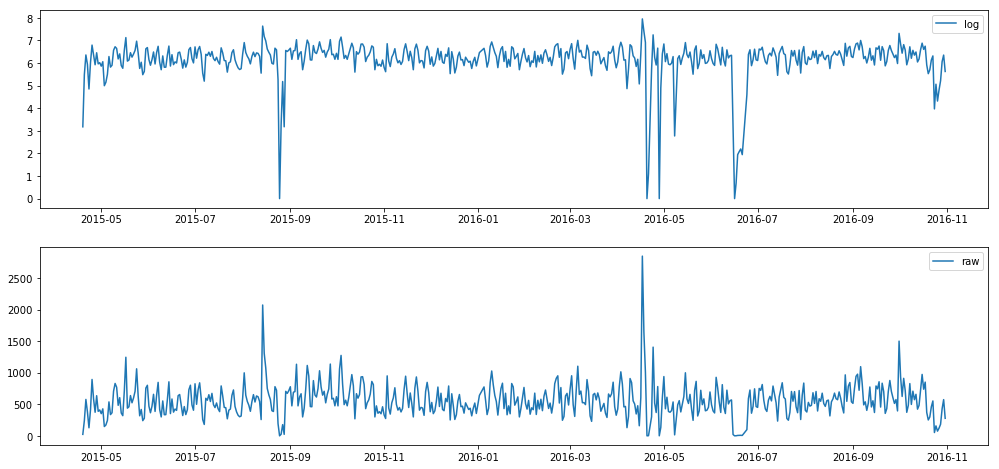

In [251]:
itemnbr=1430040
strnbr=111

# diff=order1[1]
# diffs=order2[1]*7
bev_itm=train.iloc[train.index[train.item_nbr==itemnbr]]
dates=bev_itm.date
unitsales=bev_itm.unit_sales
ts=pd.concat([dates, unitsales], axis=1)
ts_log=pd.concat([dates, np.log(unitsales)], axis=1)
ts_log=ts_log.set_index('date')
ts=ts.set_index('date')
unit_sales=ts.unit_sales

bev_itmt=test.iloc[test.index[test.item_nbr==itemnbr]]
datest=bev_itmt.date[:30]
unitsalest=bev_itmt.unit_sales[:30]
tst=pd.concat([datest, unitsalest], axis=1)
tst_log=pd.concat([datest, np.log(unitsalest)], axis=1)
tst_log=tst_log.set_index('date')
tst=tst.set_index('date')
unit_salest=tst.unit_sales

fig=plt.figure(figsize=(17,8))
fig.add_subplot(211)
plt.plot(dates, np.log(unit_sales), label='log')
plt.legend()
fig.add_subplot(212)
plt.plot(dates, unit_sales, label='raw')
plt.legend()
plt.savefig('../results/store{}/{}.png'.format(strnbr, itemnbr))


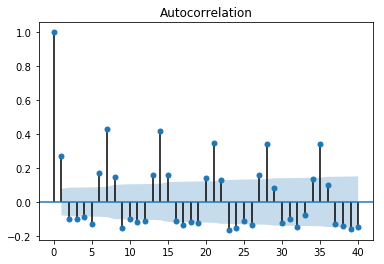

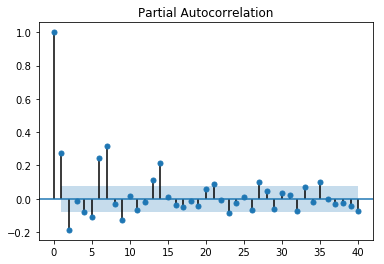

In [242]:
fig1=plt.figure()
# fig1.add_subplot(111)
fig1=plot_acf(unit_sales, lags=40)
fig1.savefig('../results/store{}/{}_acf.png'.format(strnbr,itemnbr))
fig2=plt.figure()
# fig2.add_subplot(111)
fig2=plot_pacf(unit_sales, lags=40)
fig2.savefig('../results/store{}/{}_Partial.png'.format(strnbr,itemnbr))

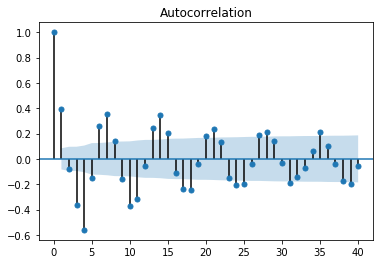

In [261]:
#diffencing
diff=4
fig=plt.figure()
unidff=unit_sales.diff(periods=diff)
fig=plot_acf(unidff[diff:], lags=40)
plt.show()
fig.savefig('../results/store{}/{}_diff{}.png'.format(strnbr,itemnbr, diff))

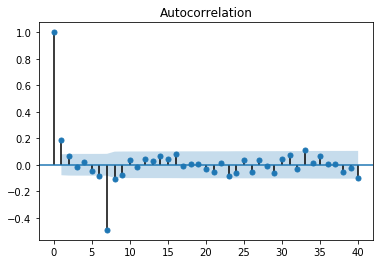

In [244]:
#seasonal differencing
diff=2*7
fig=plt.figure()
unidff=unit_sales.diff(periods=diffs)
fig=plot_acf(unidff[diffs:], lags=40)
plt.show()
fig.savefig('../results/store{}/{}_diffseasonal{}.png'.format(strnbr,itemnbr, diffs))

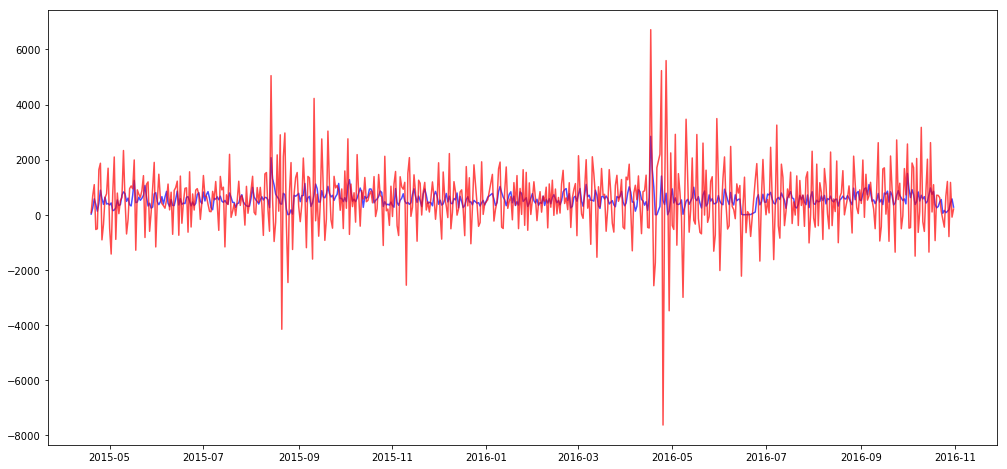

In [262]:
order1=(2,4,0)
order2=(2,2,0,7)
model=SARIMAX(ts,order=order1,seasonal_order=order2,trend='c',enforce_invertibility=False)
model_log=SARIMAX(ts_log,order=order1,seasonal_order=order2,trend='c',enforce_invertibility=False)

results=model.fit()
results2=model_log.fit()

preds=results.predict(start=1, end=len(ts)+len(tst))
preds_log=results2.predict(start=1, end=len(ts_log)+len(tst_log))

dates2=pd.date_range(start=dates.values[0], periods=len(preds_log))

fig=plt.figure(figsize=(17,8))
plt.plot(dates, unit_sales, c='blue', alpha=0.7)
plt.plot(dates, preds[:len(ts)], c='red', alpha=0.7)
plt.savefig('../results/store{}/{}_{}_{}.png'.format(strnbr,itemnbr, diff, diffs))

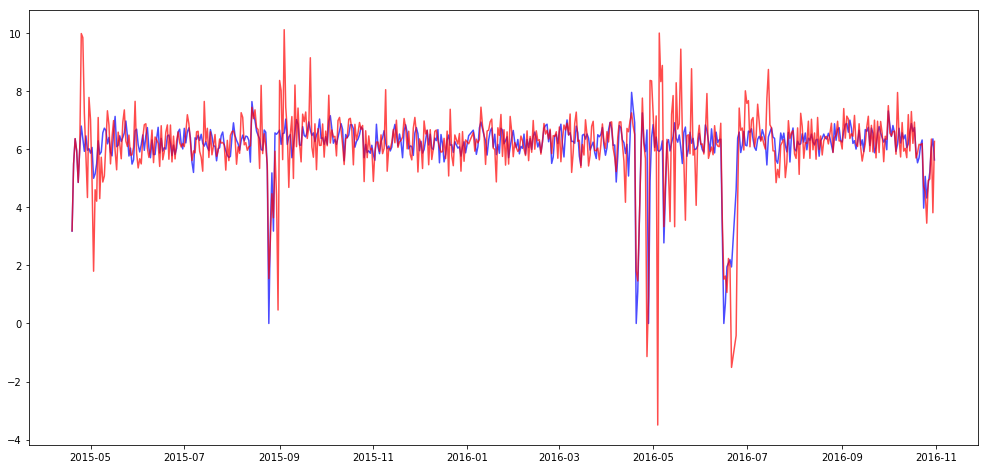

In [254]:
fig=plt.figure(figsize=(17,8))
plt.plot(dates, np.log(unit_sales), c='blue', alpha=0.7)
plt.plot(dates, preds_log[:len(ts)], c='red', alpha=0.7)
# plt.ylim([4.5,8])
plt.savefig('../results/store{}/{}_{}_{}_log.png'.format(strnbr,itemnbr, diff, diffs))

In [247]:
print(mean_squared_error(unit_sales, preds[:len(ts)]))
print(mean_squared_error(unit_sales, np.exp(preds_log[:len(ts)])))
print(results2.aic)

71721.8992296
208435493.692
850.221826858


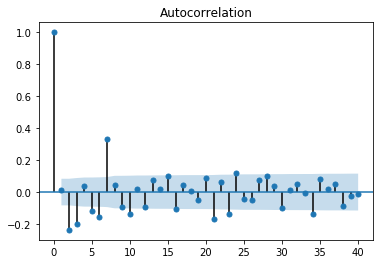

In [255]:
#acf of resiudals
residuals=unit_sales.values-preds[:len(ts)].values
fig=plot_acf(residuals, lags=40)
# sm.graphics.tsaplots.plot_pacf(unidff[1:], lags=40)
plt.show()
fig.savefig('../results/store{}/{}_{}_{}_resids.png'.format(strnbr,itemnbr, diff, diffs))

In [249]:
#test data
print(mean_squared_error(unit_salest, preds[len(ts):]))
print(np.sqrt(mean_squared_error(unit_salest, np.exp(preds_log)[len(ts):])))

118032.098373
329.624601722


C:\Users\korea\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: overflow encountered in exp
C:\Users\korea\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: overflow encountered in exp


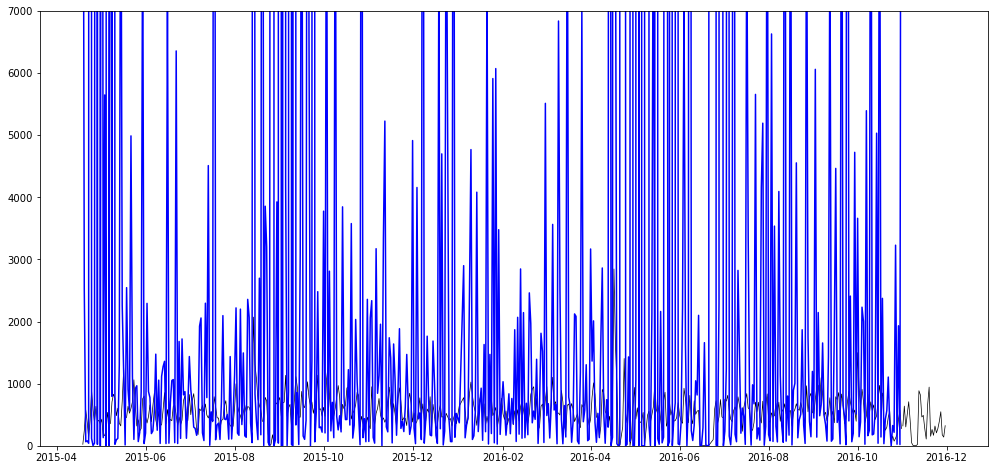

In [263]:
datest=pd.date_range(start='2016-11-01', periods=len(tst))

fig=plt.figure(figsize=(17,8))
plt.plot(dates, unit_sales, linewidth=0.7, c='black')
plt.plot(datest, unit_salest, linewidth=0.7, c='black')
plt.plot(dates, np.exp(preds_log)[:len(ts)], c='blue')
plt.plot(datest, np.exp(preds_log)[len(ts):], 'r--')
plt.ylim([0,7000])
plt.savefig('../results/store{}/test_{}.png'.format(strnbr,itemnbr))
